<b><h1 align="center">Feature and Modeling Engineering</h1></b>
<b><h1 align="center">Ingeniería de Características y Modelos</h1></b>
</i>



---

## Definición
La ingeniería de características se refiere al proceso de usar el conocimiento del dominio para seleccionar y transformar las variables más relevantes a partir de datos sin procesar al crear un modelo predictivo utilizando el aprendizaje automático o el modelado estadístico. El objetivo de la ingeniería y selección de características es mejorar el rendimiento de los algoritmos de aprendizaje automático (ML).

En este cuaderno se hará uso de diversas técnicas para extraer características predictivas que mejoren el rendimiento de los algortimos a proponer:

- **Creación de características**: La creación de características implica identificar las variables que serán más útiles en el modelo predictivo. Este es un proceso subjetivo que requiere intervención humana y creatividad. Las características existentes se mezclan a través de la suma, la resta, la multiplicación y la proporción para crear nuevas características derivadas que tienen un mayor poder predictivo.
- **Transformaciones**: La transformación implica manipular las variables predictoras para mejorar el rendimiento del modelo; por ejemplo, garantizar que el modelo sea flexible en la variedad de datos que puede ingerir; garantizar que las variables estén en la misma escala, haciendo que el modelo sea más fácil de entender; mejorar la precisión; y evitar errores computacionales asegurándose de que todas las características estén dentro de un rango aceptable para el modelo.
- **Extracción de características**: La extracción de características es la creación automática de nuevas variables extrayéndolas de datos sin procesar. El propósito de este paso es reducir automáticamente el volumen de datos en un conjunto más manejable para el modelado. Algunos métodos de extracción de características incluyen análisis de clústeres, análisis de texto, algoritmos de detección de bordes y análisis de componentes principales.
- **Selección de características**: Los algoritmos de selección de características esencialmente analizan, juzgan y clasifican varias características para determinar qué características son irrelevantes y deben eliminarse, qué características son redundantes y deben eliminarse, y qué características son más útiles para el modelo y deben priorizarse.

## Objetivo
Lo que se busca es predecir las ventas de períodos futuros. Para ello se cuenta con los datos históricos de ventas (datos internos) y los datos hístóricos de variables macroeconómicas del mercado (datos externos). A fin de predir ventas en función de otras variables será necesario unificar las dos fuentes en un único DataFrame usando como base un mismo marco temporal. Esto se ejecuta en las siguientes líneas de código.

In [824]:
# Cargar bibliotecas
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [825]:
# Cargar datos
ventas = pd.read_hdf("Data/data.h5", key="ventas", mode="r")
vme = pd.read_hdf("Data/data.h5", key="vme", mode="r")

In [826]:
date_index = ventas.set_index('Fec. Fact. Venta')
by_date = date_index.groupby([lambda x: x.year, lambda x: x.month, lambda x: x.day]).sum()

In [827]:
from datetime import datetime

# DataFrame con ventas por día.
data = {
    "date": [datetime(i[0], i[1], i[2]) for i in by_date["Valor"].index],
    "sell": [sell for sell in by_date["Valor"]]
}
sell_by_date = pd.DataFrame(data=data)

# Rango de fechas completo
date_range = pd.date_range(start=vme.index.min(), end=vme.index.max())

# DataFrame solo con rango de fechas
df_dates = pd.DataFrame(data={"date":date_range})

# DataFrame unificado con ventas y variables macroeconómicas
df = pd.merge(df_dates, vme, how="left", left_on="date", right_on="Fecha")
df = pd.merge(df, sell_by_date, how="left", on="date")
df = df.fillna(value=0)
df.set_index("date", inplace=True)

# Eliminar datos de 2022
df = df.loc[df.index.to_series() <= datetime(2021, 12, 31)]

df.tail()

,USDCHP,IPC,IMACEC,PIB,TCM,TDN,UF,sell
date,,,,,,,,
2021-12-27,863.29,0.8,10.1,40449.0,124.49,7.19,30971.80,90301233.0
2021-12-28,858.59,0.8,10.1,40449.0,123.85,7.19,30976.79,98065210.0
2021-12-29,855.94,0.8,10.1,40449.0,123.52,7.19,30981.77,89322481.0
2021-12-30,850.25,0.8,10.1,40449.0,122.62,7.19,30986.76,52230325.0
2021-12-31,850.25,0.8,10.1,40449.0,122.62,7.19,30991.74,67052318.0


## Creación de características

### Medias móviles
Debido a que no todos los días se producen eventos de ventas, se comienza por crear medias móviles de distintos rangos temporales a fín de facilitar el entrenamiento. Si se introdujeran valores de venta diaria sin procesar, debido a que en su mayoría se tratará de valores iguales a cero, esto podría causar un sesgo en el proceso de entrenamiento. Al utilizar medias móviles en lugar de datos en bruto, se minimiza los períodos de tiempo sin actividad visible para las características de entrada.

Como las medias móviles tendrán valores null antes de completar la cantidad mínima de su ventana de promedio, se van a rellenar los valores null con el siguiente valor distinto de null.

In [828]:
# Creación de medias móviles
# sma_x -> sell moving average by x days
df["sma_5"] = df["sell"].rolling(window=5).mean()
df["sma_10"] = df["sell"].rolling(window=10).mean()
df["sma_15"] = df["sell"].rolling(window=15).mean()
df["sma_20"] = df["sell"].rolling(window=20).mean()
df["sma_30"] = df["sell"].rolling(window=30).mean()
df["sma_50"] = df["sell"].rolling(window=50).mean()
df["sma_100"] = df["sell"].rolling(window=100).mean()
df.fillna(method="bfill", inplace=True)

df.head()

,USDCHP,IPC,IMACEC,PIB,TCM,TDN,UF,sell,sma_5,sma_10,sma_15,sma_20,sma_30,sma_50,sma_100
date,,,,,,,,,,,,,,,
2010-01-01,507.1,0.5,2.0,27890.0,103.41,9.23,20939.49,0.0,0.0,1044059.2,3285049.8,2946148.25,4.930117e+06,4215153.98,5040908.11
2010-01-02,507.1,0.5,2.0,27890.0,103.41,9.23,20936.11,0.0,0.0,1044059.2,3285049.8,2946148.25,4.930117e+06,4215153.98,5040908.11
2010-01-03,507.1,0.5,2.0,27890.0,103.41,9.23,20932.72,0.0,0.0,1044059.2,3285049.8,2946148.25,4.930117e+06,4215153.98,5040908.11
2010-01-04,507.1,0.5,2.0,27890.0,103.41,9.23,20929.34,0.0,0.0,1044059.2,3285049.8,2946148.25,4.930117e+06,4215153.98,5040908.11
2010-01-05,505.7,0.5,2.0,27890.0,103.56,9.23,20925.95,0.0,0.0,1044059.2,3285049.8,2946148.25,4.930117e+06,4215153.98,5040908.11


<AxesSubplot:title={'center':'Media Móvil de Ventas de 100 días'}, xlabel='Fecha', ylabel='Ventas (CHP)'>

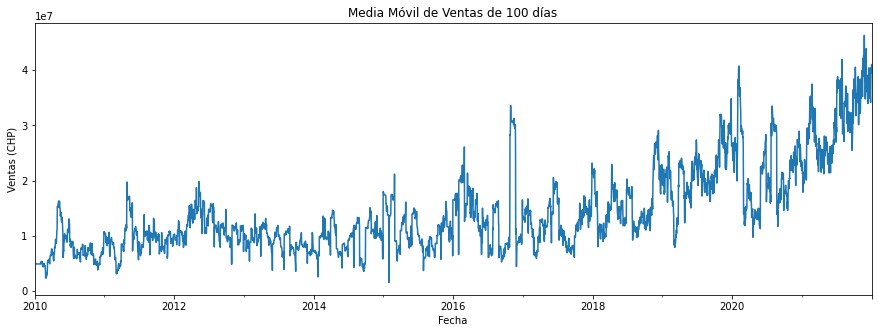

In [829]:
df["sma_30"].plot(figsize=(15, 5),
                   title="Media Móvil de Ventas de 100 días",
                   xlabel="Fecha",
                   ylabel="Ventas (CHP)")

### Periodicidad

Es de esperar que hayan comportamientos de ventas cíclicos en el tiempo. Esto puede ser debido a la renovación periódica de ventas, a que ciertos meses estén asociados con gastos especiales (como los gastos navideños) o a la ocurrencia de eventos promocionales de descuento en ciertas épocas del año. Hay varias formas en las que se puede lidiar con la periodicidad. Se pueden obtener señales útiles al utilizar transformaciones de seno y coseno para limpiar señales semanales, mensuales y anuales.

### Transformada Rápida de Fourier

Si no tenemos información sobre las frecuencias más importantes, estas pueden ser extraidas con la transformada de Fourier. Al aplicar "Fast Fourier Transformation" sobre la serie de interés podremos observar picos en las frecuencias más significativas. Dichas frecuencias pueden ser utilizadas para crear características de periodicidad.

En primer lugar se procede a ejecutar y graficar la tranformada de Fourier.


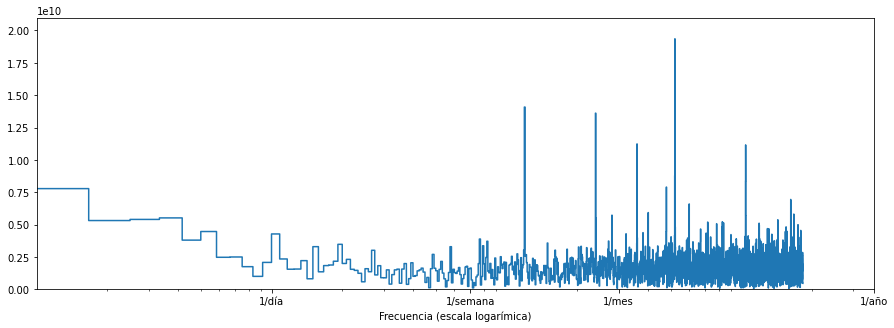

In [830]:
import tensorflow as tf

fft = tf.signal.rfft(df["sell"])
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df["sell"])
days_per_year = 365.2524
years_per_dataset = n_samples_d / days_per_year

f_per_year = f_per_dataset / years_per_dataset

fig, ax = plt.subplots(figsize=(15, 5))
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 21000000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7, 30, 365.2524], labels=["1/día", "1/semana", "1/mes", "1/año"])
_ = plt.xlabel("Frecuencia (escala logarímica)")

A continuación, se determinan las frecuencias picos. En este caso se buscan las 5 frecuencias más importantes y se evitan los valores de frecuencia cero.

In [831]:
maxs = []
ffti = np.abs(fft)
for i in range(7):
    index_max = np.argmax(ffti)
    if not index_max == 0:
        maxs.append(index_max)
    ffti = np.delete(ffti, index_max)
max_frequencies = f_per_year[maxs]
print(max_frequencies)

[ 52.08367556  11.83341109  23.75015606  35.66690103 103.83401561]


Con estas frecuencias podemos crear características de periodicidad más significativas

In [832]:
for i, freq in enumerate(max_frequencies):
    name = f"fft_{i+1}"
    df[name] = df["sell"].rolling(window=int(freq)).mean().fillna(method="bfill")

<AxesSubplot:title={'center':'Media Móvil de Ventas de 52 días - FFT=52'}, xlabel='Fecha', ylabel='Ventas (CHP)'>

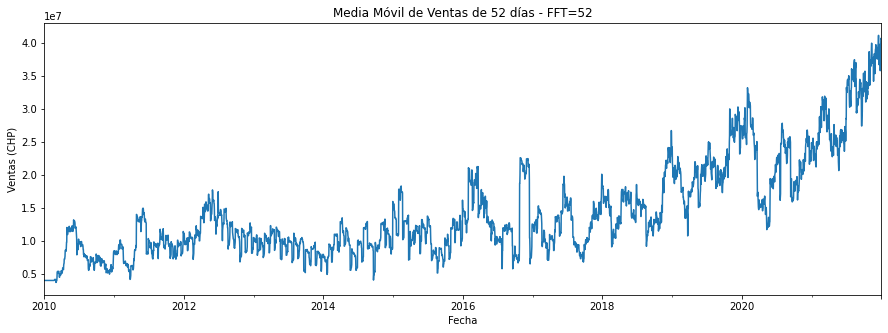

In [833]:
fig, ax = plt.subplots(figsize=(15, 5))
df["fft_1"].plot(title="Media Móvil de Ventas de 52 días - FFT=52",
                   xlabel="Fecha",
                   ylabel="Ventas (CHP)")

## Subdivición de datos

De los datos disponibles 70% será para entrenamiento, 20% para validación y 10% para prueba. Además, no se tomarán aleatoriamente los valores. Esto es por dos razones:
1. Esto asegura que sea posible tomar los datos en ventanas de ejemplares consecutivos.
2. Igualmente asegura que los resultados de validación y prueba sean más realistas al ser evaluados en los datos colectados luego de que el modelo fue entrenado.

In [834]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalización de datos
Es importante escalar las características antes de entrenar una red neuronal. La normalización es una forma común de hacer esta escala: restar la media y dividir por la desviación estándar de cada característica.

La media y la desviación estándar solo deben calcularse utilizando los datos de entrenamiento para que los modelos no tengan acceso a los valores en los conjuntos de validación y prueba.

También es discutible que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento durante el entrenamiento, y que esta normalización debería hacerse usando promedios móviles. Sin embargo, en aras de la simplicidad, se usa un promedio simple.

In [835]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Se pueden revisar los resultados luego de la normalización haciendo uso de un gráfico de violín para cada característica. 

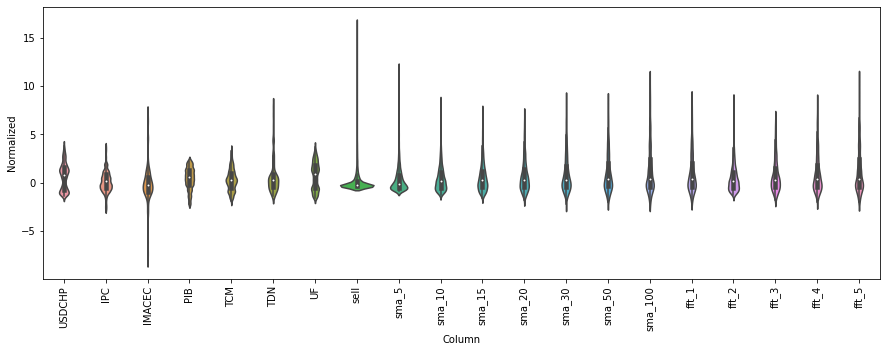

In [836]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(15, 5))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Ventana de datos
Los modelos basados en redes neuronales realizarán sus predicciones basados en una ventana de muestras consecutivas de los datos.
Las características principales de las ventanas de entrada son:
- El ancho (número de pasos de tiempo) de las ventanas de entrada y etiqueta.
- El tiempo desfasado entre ellos
- Qué característica se utilizan como entradas y como etiqueta.

<img src="Images/ventana_datos.png" alt="ventana de datos" style="width: 700px; align:center"/>


### 1. Índices y desfases
Se comienza creando una clase llamada "WindowGenerator"

In [837]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
    
        # Guardar los datos en bruto
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Trabajar el índice de la etiqueta y características
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Parámetros de ventana de datos
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        """Representación del objeto WindowGenerator"""
        return '\n'.join([
            f'Tamaño total de ventana: {self.total_window_size}',
            f'Índices de entrada: {self.input_indices}',
            f'Índices de etiqueta: {self.label_indices}',
            f'Nombre(s) de columna(s) de etiqueta(s): {self.label_columns}'])

### 2. División

Dado una lista de entradas consecutivas el método convertirá dichas entradas en una ventana de entradas y una ventana de etiquetas.

In [838]:
def split_window(self, features):
    """Dado una lista de entradas consecutivas el método convertirá dichas
    entradas en una ventana de entradas y una ventana de etiquetas."""
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # La divición no preserva información de forma estática, así que es necesario
    # configurar manuealmente las formas. De esta manera los dataset son más 
    # fáciles de inspeccionar.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

### 3. Graficar
Un método que permite una visualización simple de la ventana dividida

In [839]:
def plot(self, model=None, plot_col="sma_30", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize= (15,7))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normalizado]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Entradas', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
        print(label_col_index)
        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Etiquetas', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predicciones',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Tiempo [d]')

WindowGenerator.plot = plot

### 4. Crear tf.data.Datasets

Este método toma un pandas.DataFrame y los convierto en tf.data.Dataset de pares.

In [840]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

Agregar propiedades para acceder a los conjuntos de entrenamiento, validación y prueba.

In [841]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)
    
@property
def val_array(self):
    return np.array(self.val_df, dtype=np.float32)

@property
def test_array(self):
    return np.array(self.test_df, dtype=np.float32)

@property
def example(self):
    """ Obtiene y coloca en caché un conjunto de ejemplos de entradas,
    etiquetas para graficar."""
    result = getattr(self, '_example', None)
    if result is None:
        # No fue hallado ningún lote de ejemplo,
        # así que es toma una desde el el conjunto de entrenamiento.
        result = next(iter(self.train))
        # Y se cachea para la siguiente vez.
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.val_array = val_array
WindowGenerator.test_array = test_array
WindowGenerator.example = example

## Modelos predictivos simples

Se propone predecir las ventas promedio de períodos futuros. Para ello será necesario crear una "etiqueta" que corresponda a una media móvil con un desfase igual al período a predecir. De esta forma cada línea del DataFrame contará tanto con las características de entrada como con la etiqueta de salida.

A fin de facilitar la prueba de varios periodos de predicción se parametrizará para facilitar la creación de etiquetas con desfase.

In [842]:
# Creación de etiqueta
period = 100
label = df["sell"].rolling(window=period).mean()

# Aplicación del offset
label = label.iloc[period:].tolist()

# Recortar dataset en función del offset
df = df.iloc[:-period]

# Agregar etiqueta a dataset
df["label"] = np.array(label)
df.head()

,USDCHP,IPC,IMACEC,PIB,TCM,TDN,UF,sell,sma_5,sma_10,...,sma_20,sma_30,sma_50,sma_100,fft_1,fft_2,fft_3,fft_4,fft_5,label
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,507.1,0.5,2.0,27890.0,103.41,9.23,20939.49,0.0,0.0,1044059.2,...,2946148.25,4.930117e+06,4215153.98,5040908.11,4.053033e+06,2.347066e+06,3.178912e+06,4.552096e+06,5.241881e+06,5040908.11
2010-01-02,507.1,0.5,2.0,27890.0,103.41,9.23,20936.11,0.0,0.0,1044059.2,...,2946148.25,4.930117e+06,4215153.98,5040908.11,4.053033e+06,2.347066e+06,3.178912e+06,4.552096e+06,5.241881e+06,5069714.00
2010-01-03,507.1,0.5,2.0,27890.0,103.41,9.23,20932.72,0.0,0.0,1044059.2,...,2946148.25,4.930117e+06,4215153.98,5040908.11,4.053033e+06,2.347066e+06,3.178912e+06,4.552096e+06,5.241881e+06,5399137.57
2010-01-04,507.1,0.5,2.0,27890.0,103.41,9.23,20929.34,0.0,0.0,1044059.2,...,2946148.25,4.930117e+06,4215153.98,5040908.11,4.053033e+06,2.347066e+06,3.178912e+06,4.552096e+06,5.241881e+06,5525497.34
2010-01-05,505.7,0.5,2.0,27890.0,103.56,9.23,20925.95,0.0,0.0,1044059.2,...,2946148.25,4.930117e+06,4215153.98,5040908.11,4.053033e+06,2.347066e+06,3.178912e+06,4.552096e+06,5.241881e+06,5577625.10


La siguiente función facilitará el proceso repetitivo de entrenar y probar diversos modelos

In [843]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

val_performance = {}
performance = {}

def train_test_model(model, x, y, name=""):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=False)
    model.fit(x_train, y_train)
    y_predictions =  model.predict(x_test)
    y_predictions = pd.DataFrame(np.array(y_predictions)).set_index(y_test.index)

    score = model.score(x_test, y_test)
    mse = mean_squared_error(y_test, y_predictions)
    mae = mean_absolute_error(y_test, y_predictions)
    print(f"Coeficiente de determinación R^2: {score:.4}")
    print(f"Error cuadrático medio: {mse:.4}")
    print(f"Error absoluto medio: {mae:.4}")
    
    tscore = model.score(x_train, y_train)
    ty_predictions =  model.predict(x_train)
    tmse = mean_squared_error(y_train, ty_predictions)
    tmae = mean_absolute_error(y_train, ty_predictions)
    
    # performance[name] = [0, tmse, tmae, tscore]
    # val_performance[name] = [0, mse, mae, score]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.plot(y_predictions, label="Predicción")
    plt.plot(y_test, label="Datos de Prueba")
    ax.legend() 
    return model

Definamos las características a tomar en cuenta y los conjuntos de entrenamiento y prueba.

In [844]:
from sklearn.model_selection import train_test_split

# Todas las características
# "USDCHP", "IPC", "IMACEC", "PIB", "TCM", "TDN", "UF", "sma_5", "sma_10", "sma_15", "sma_20", "sma_30", "sma_50", "sma_100"

features = ["USDCHP", "IPC", "IMACEC", "PIB", "TCM", "TDN", "UF", "sma_5", "sma_10", "sma_15", "sma_20", "sma_30", "sma_50", "sma_100"]
label = "label"

x = df[features]
y = df[label]

### Regresión Lineal
Comenzaremos con el modelo más simple posible, una **Regresión Lineal**.

Coeficiente de determinación R^2: -1.372
Error cuadrático medio: 6.592e+13
Error absoluto medio: 7.337e+06


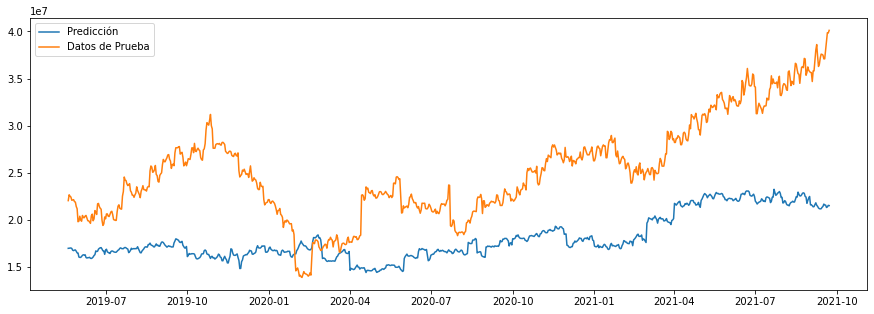

In [845]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg = train_test_model(lin_reg, x, y, "Reg. Lineal")

### Regresión Polinómica

Coeficiente de determinación R^2: -7.107
Error cuadrático medio: 2.253e+14
Error absoluto medio: 1.106e+07


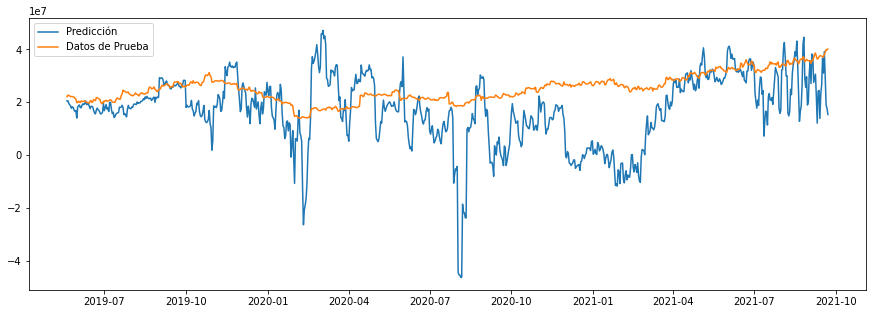

In [846]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)

pol_reg = LinearRegression()
pol_reg = train_test_model(pol_reg, x_poly, y, "Reg. Poli.")

### Regresión de Bosques Aleatorios

Coeficiente de determinación R^2: -1.515
Error cuadrático medio: 6.991e+13
Error absoluto medio: 6.639e+06


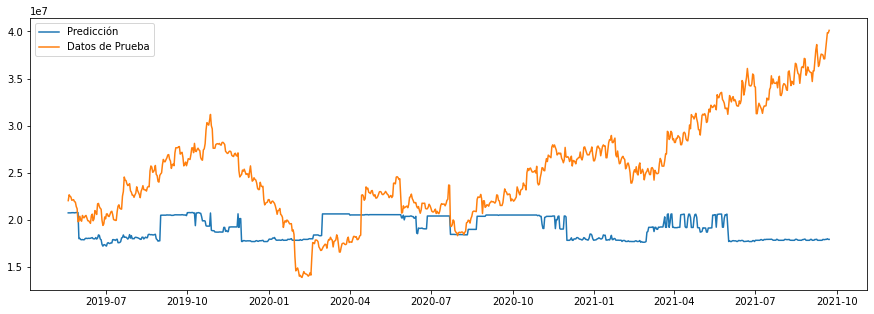

In [847]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(max_depth=5, random_state=0)
tf_reg = train_test_model(rf_reg, x, y, "Bosque Aleat.")

## Modelos predictivos basados en ventanas
Como se van a entrenar muchos modelos, es ventajoso empaquetar el procedimiento de entrenamiento en una función:

In [848]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def compile_and_fit(model, window, patience=2, epochs=20, learning_rate=0.001):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.losses.MeanSquaredError(),
                           tf.metrics.MeanAbsoluteError(),
                           coeff_determination])

    history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

### Modelos de un solo paso de salida
Los modelos más simples que se puede construir son aquellos que predigan una única característica en el futuro, basado unicamente en las condiciones actuales. Esto implicaría una ventana de entrada = 1, y una ventana de etiqueta = 1. A continuación, se usan estos valores para probar el funcionamiento de la clase WindowGenerator.

In [849]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=["sma_30"])
single_step_window

Tamaño total de ventana: 2
Índices de entrada: [0]
Índices de etiqueta: [1]
Nombre(s) de columna(s) de etiqueta(s): ['sma_30']

In [850]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Forma de entradas (lote, ventana, características): {example_inputs.shape}')
    print(f'Forma de etiquetas (lote, ventana, etiquetas): {example_labels.shape}')

Forma de entradas (lote, ventana, características): (32, 1, 20)
Forma de etiquetas (lote, ventana, etiquetas): (32, 1, 1)


#### A. Modelo denso de varios pasos de entrada

Un modelo de paso único no tiene contexto para los valores actuales de sus entradas. No puede ver cómo las características de entrada están cambiando con el tiempo. Para abordar este problema, el modelo necesita acceso a varios pasos de tiempo al realizar predicciones:

In [851]:
CONV_WIDTH = 20
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=["sma_30"])

conv_window

Tamaño total de ventana: 21
Índices de entrada: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Índices de etiqueta: [20]
Nombre(s) de columna(s) de etiqueta(s): ['sma_30']

0
0
0


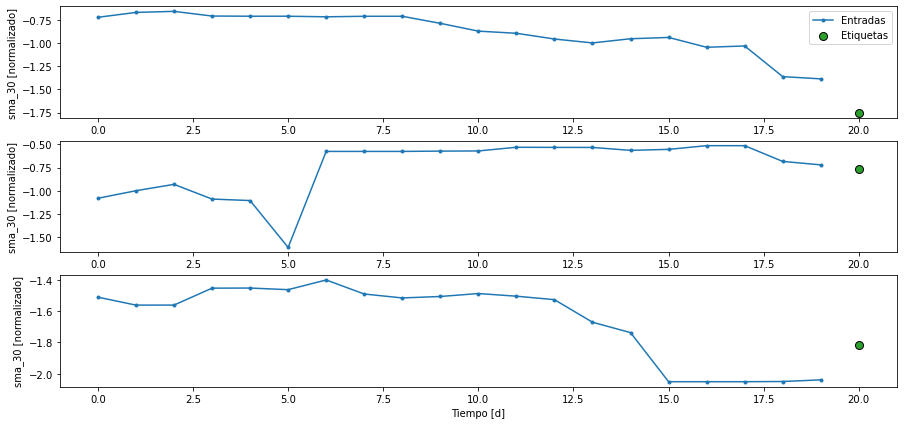

In [852]:
conv_window.plot()

##### Creación del modelo

In [853]:
multi_step_dense = tf.keras.Sequential([
    # Forma: (tiempo, características) => (tiempo * características)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Volver a agregar la dimensión de tiempo
    # Forna: (salidas) => (1, salidas)
    tf.keras.layers.Reshape([1, -1]),
])

##### Entrenamiento

In [854]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/20
96/96 [==============================] - 1s 3ms/step - loss: 0.2007 - mean_squared_error: 0.1993 - mean_absolute_error: 0.3056 - coeff_determination: 0.7611 - val_loss: 0.3241 - val_mean_squared_error: 0.3228 - val_mean_absolute_error: 0.4201 - val_coeff_determination: 0.8406
Epoch 2/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0925 - mean_squared_error: 0.0952 - mean_absolute_error: 0.2058 - coeff_determination: 0.8900 - val_loss: 0.3566 - val_mean_squared_error: 0.3570 - val_mean_absolute_error: 0.4486 - val_coeff_determination: 0.8096
Epoch 3/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0796 - mean_squared_error: 0.0792 - mean_absolute_error: 0.1864 - coeff_determination: 0.9050 - val_loss: 0.4300 - val_mean_squared_error: 0.4297 - val_mean_absolute_error: 0.5171 - val_coeff_determination: 0.7875


##### Verificación

In [855]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

27/27 [==============================] - 0s 959us/step - loss: 0.4300 - mean_squared_error: 0.4301 - mean_absolute_error: 0.5171 - coeff_determination: 0.7898


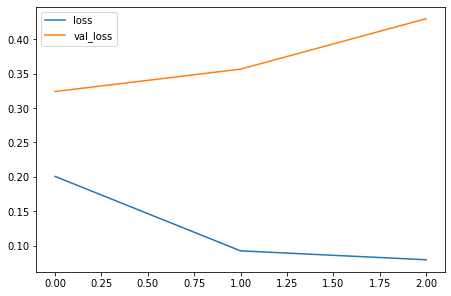

In [856]:
# Graficar evolución de entrenamiento

fig=plt.figure(figsize=(60, 40))

## error
fig.add_subplot(7, 7, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.show()

0
0
0


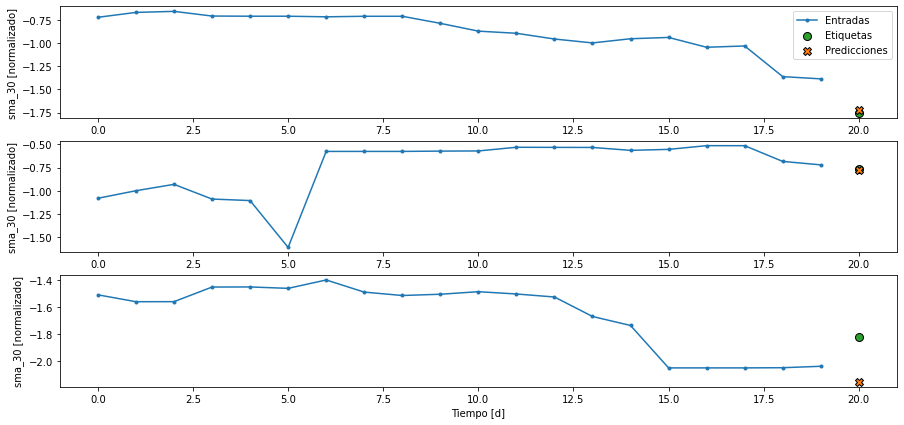

In [857]:
conv_window.plot(multi_step_dense)

In [858]:
multi_step_dense.save("Modelos\multi_step_dense.h5")

#### B. Red Neuronal Convolucional

In [859]:
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['sma_30'])

print("Ventana amplia de convolución")
print('Forma de entrada:', wide_conv_window.example[0].shape)
print('Forma de salida:', wide_conv_window.example[1].shape)

Ventana amplia de convolución
Forma de entrada: (32, 49, 20)
Forma de salida: (32, 30, 1)


In [860]:
for example_inputs, example_labels in wide_conv_window.train.take(1):
    print(f'Forma de entradas (lote, ventana, características): {example_inputs.shape}')
    print(f'Forma de etiquetas (lote, ventana, etiquetas): {example_labels.shape}')

Forma de entradas (lote, ventana, características): (32, 49, 20)
Forma de etiquetas (lote, ventana, etiquetas): (32, 30, 1)


In [861]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [862]:
history = compile_and_fit(conv_model, wide_conv_window, patience=2)

val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)
performance['Conv'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

Epoch 1/20
95/95 [==============================] - 1s 6ms/step - loss: 0.2024 - mean_squared_error: 0.2015 - mean_absolute_error: 0.2832 - coeff_determination: 0.7692 - val_loss: 0.2197 - val_mean_squared_error: 0.2197 - val_mean_absolute_error: 0.3206 - val_coeff_determination: 0.8947
Epoch 2/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0554 - mean_squared_error: 0.0553 - mean_absolute_error: 0.1467 - coeff_determination: 0.9384 - val_loss: 0.1784 - val_mean_squared_error: 0.1781 - val_mean_absolute_error: 0.2767 - val_coeff_determination: 0.9147
Epoch 3/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0429 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1248 - coeff_determination: 0.9512 - val_loss: 0.1599 - val_mean_squared_error: 0.1601 - val_mean_absolute_error: 0.2586 - val_coeff_determination: 0.9247
Epoch 4/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0367 - mean_squared_error: 0.0368 - mean_absolute_error: 0.114

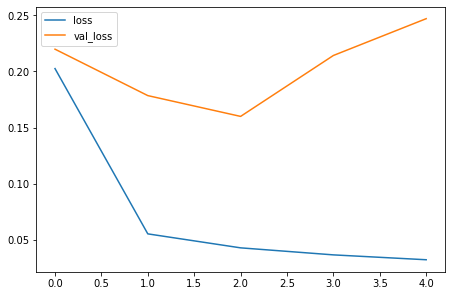

In [863]:
# Graficar evolución de entrenamiento

fig=plt.figure(figsize=(60, 40))

## error
fig.add_subplot(7, 7, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.show()

0
0
0


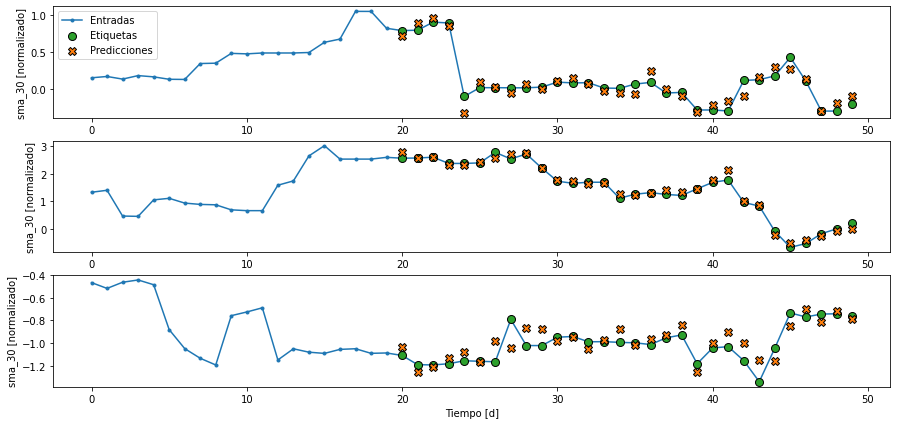

In [864]:
wide_conv_window.plot(conv_model)

In [865]:
conv_model.save("Modelos/conv_model.h5")

##### Comentarios
En comparación con las otras configuraciones, esta red es la ofrece un mejor desempeño. En el gráfico central se puede observar como el algoritmo predice una caida fuerte a los 24 días. Igualmente en el gráfico inferior el mismo algoritmo precide un aumento considerable de ventas para el día 22.

#### C. Red Neuronal Recurrente

In [866]:
wide_rnn_window = WindowGenerator(
    input_width=30,
    label_width=30,
    shift=1,
    label_columns=['sma_30'])

print("Ventana amplia de convolución")
print('Forma de entrada:', wide_rnn_window.example[0].shape)
print('Forma de salida:', wide_rnn_window.example[1].shape)

Ventana amplia de convolución
Forma de entrada: (32, 30, 20)
Forma de salida: (32, 30, 1)


In [867]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [868]:
history = compile_and_fit(lstm_model, wide_rnn_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_rnn_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_rnn_window.test, verbose=0)

Epoch 1/20
95/95 [==============================] - 3s 13ms/step - loss: 0.4077 - mean_squared_error: 0.4075 - mean_absolute_error: 0.4323 - coeff_determination: 0.5785 - val_loss: 1.6556 - val_mean_squared_error: 1.6670 - val_mean_absolute_error: 0.9351 - val_coeff_determination: 0.2289
Epoch 2/20
95/95 [==============================] - 1s 10ms/step - loss: 0.1546 - mean_squared_error: 0.1546 - mean_absolute_error: 0.2605 - coeff_determination: 0.8367 - val_loss: 1.0100 - val_mean_squared_error: 0.9970 - val_mean_absolute_error: 0.6973 - val_coeff_determination: 0.5314
Epoch 3/20
95/95 [==============================] - 1s 10ms/step - loss: 0.1162 - mean_squared_error: 0.1162 - mean_absolute_error: 0.2188 - coeff_determination: 0.8739 - val_loss: 0.8613 - val_mean_squared_error: 0.8707 - val_mean_absolute_error: 0.6356 - val_coeff_determination: 0.5866
Epoch 4/20
95/95 [==============================] - 1s 9ms/step - loss: 0.0998 - mean_squared_error: 0.0998 - mean_absolute_error: 0.

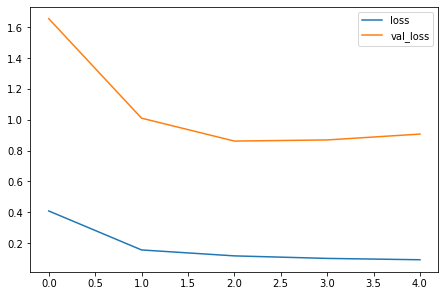

In [869]:
# Graficar evolución de entrenamiento

fig=plt.figure(figsize=(60, 40))

## error
fig.add_subplot(7,7,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.show()

0
0
0


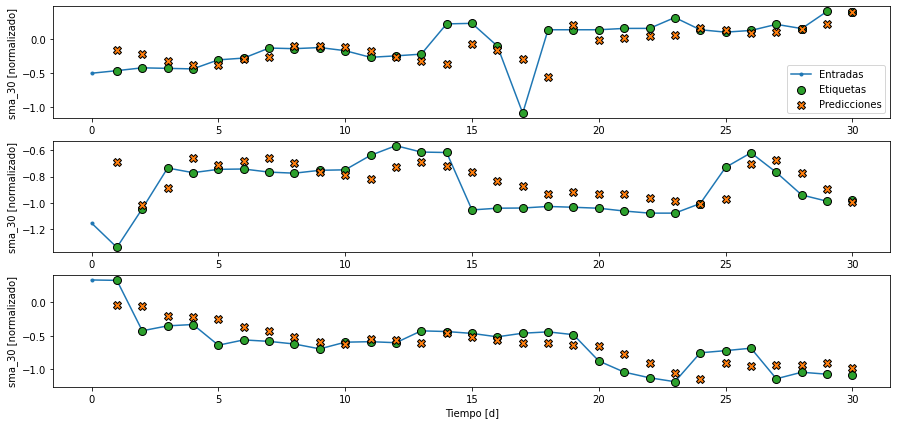

In [870]:
wide_rnn_window.plot(lstm_model)

In [871]:
lstm_model.save("Modelos/lstm_model.h5")

#### D. Red Neuronal Convolucional con múltiples pasos de salida

12
12
12


Tamaño total de ventana: 37
Índices de entrada: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Índices de etiqueta: [30 31 32 33 34 35 36]
Nombre(s) de columna(s) de etiqueta(s): None

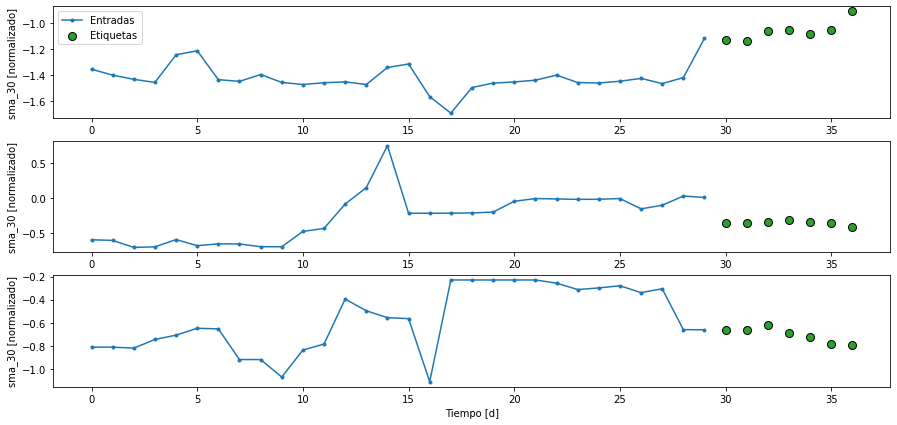

In [872]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Epoch 1/20
95/95 [==============================] - 1s 4ms/step - loss: 0.4221 - mean_squared_error: 0.4215 - mean_absolute_error: 0.4386 - coeff_determination: 0.5685 - val_loss: 0.8519 - val_mean_squared_error: 0.8719 - val_mean_absolute_error: 0.5998 - val_coeff_determination: 0.7549
Epoch 2/20
95/95 [==============================] - 0s 3ms/step - loss: 0.2511 - mean_squared_error: 0.2507 - mean_absolute_error: 0.2974 - coeff_determination: 0.7470 - val_loss: 0.6863 - val_mean_squared_error: 0.7043 - val_mean_absolute_error: 0.5381 - val_coeff_determination: 0.8012
Epoch 3/20
95/95 [==============================] - 0s 2ms/step - loss: 0.2238 - mean_squared_error: 0.2237 - mean_absolute_error: 0.2672 - coeff_determination: 0.7753 - val_loss: 0.6807 - val_mean_squared_error: 0.6795 - val_mean_absolute_error: 0.5143 - val_coeff_determination: 0.8083
Epoch 4/20
95/95 [==============================] - 0s 3ms/step - loss: 0.2137 - mean_squared_error: 0.2136 - mean_absolute_error: 0.255

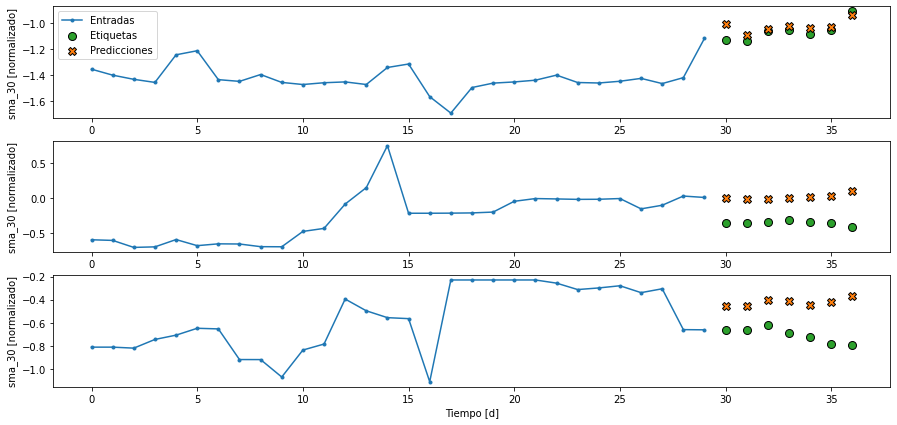

In [873]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

val_performance['Conv_Mult'] = multi_conv_model.evaluate(multi_window.val)
performance['Conv_Mult'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

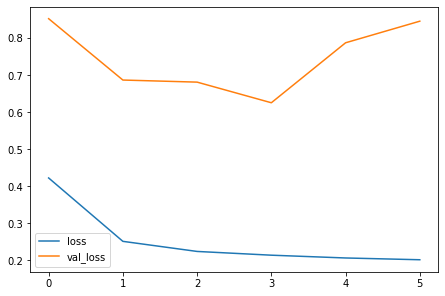

In [874]:
# Graficar evolución de entrenamiento

fig=plt.figure(figsize=(60, 40))

## error
fig.add_subplot(7,7,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.show()

In [875]:
multi_conv_model.save("Modelos/multi_conv.h5")

#### Rendimiento

2


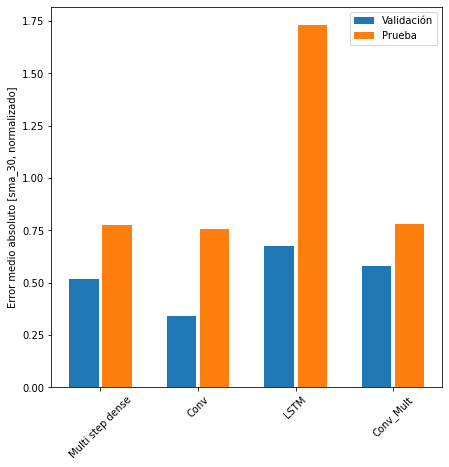

In [876]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
print(metric_index)
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

fig=plt.figure(figsize=(7, 7))
plt.ylabel('Error medio absoluto [sma_30, normalizado]')
plt.bar(x - 0.17, val_mae, width, label='Validación')
plt.bar(x + 0.17, test_mae, width, label='Prueba')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

1


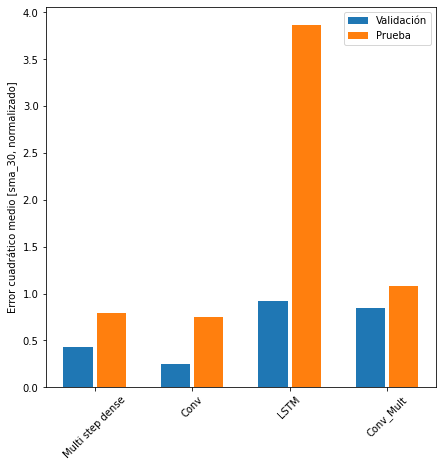

In [877]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index(metric_name)
print(metric_index)
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]
fig=plt.figure(figsize=(7, 7))
plt.ylabel('Error cuadrático medio [sma_30, normalizado]')
plt.bar(x - 0.17, val_mae, width, label='Validación')
plt.bar(x + 0.17, test_mae, width, label='Prueba')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

3


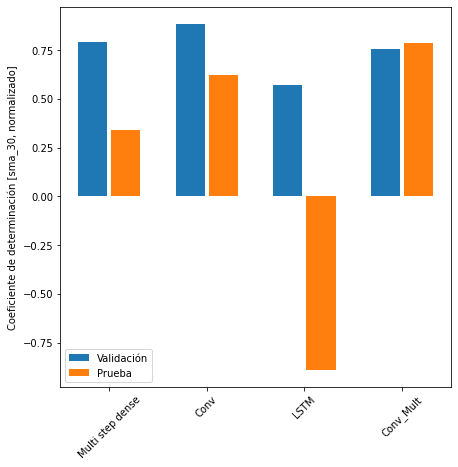

In [878]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'coeff_determination'
metric_index = lstm_model.metrics_names.index(metric_name)
print(metric_index)
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

fig=plt.figure(figsize=(7, 7))
plt.ylabel('Coeficiente de determinación [sma_30, normalizado]')
plt.bar(x - 0.17, val_mae, width, label='Validación')
plt.bar(x + 0.17, test_mae, width, label='Prueba')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

Se puede observar que el mejor rendimiento lo produce la Red Neuronal Convolucional

In [879]:
multi_window.test_array.shape

(439, 20)

In [880]:
inputs, labels = multi_window.example

In [881]:
predictions = multi_conv_model(inputs)
media_predictions = np.mean(predictions[0,:,12].numpy())
media_labels = np.mean(labels[0,:,12].numpy())
error = (1 - media_predictions / media_labels)

In [882]:
print(f"Media de etiquetas: {media_labels}")
print(f"Media de predicciones: {media_predictions}")
print(f"Error de predicción: {error} %")

Media de etiquetas: -1.0596510171890259
Media de predicciones: -1.0217278003692627
Error de predicción: 0.03578841686248779 %


In [883]:
msqrs = []
for n in range(30):
    inputs, labels = multi_window.example
    predictions = multi_conv_model(inputs)
    media_predictions = np.mean(predictions[n,:,12].numpy())
    media_labels = np.mean(labels[n,:,12].numpy())
    error = (1 - media_predictions / media_labels)
    msqrs.append(np.sqrt(np.power(error,2)))

In [884]:
mean_error = np.mean(msqrs)
print(f"Error de media para 30 días: {mean_error}")

Error de media para 30 días: 6.762071993326147
